In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import json
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import re

import patsy

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from scipy.stats import ttest_ind

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import classification_report, confusion_matrix

from joblib import Parallel, delayed

from IPython.display import display

In [2]:
%%time
df = pd.read_csv("./data/joined_data_all.txt", sep="\t", parse_dates=["created_at", "u_created_at"])
df["opinionated"] = df.label != "neutral"
df["followers_friends"] = (df[u'u_followers'] + 1)/(df[u'u_friends'] + 1)
df["statuses_followers"] = (df[u'u_statuses'] + 1)/(df[u'u_followers'] + 1)
df["statuses_friends"] = (df[u'u_statuses'] + 1)/(df[u'u_friends'] + 1)
df["user_age"] = (df.created_at - df.u_created_at).dt.round("D").apply(lambda x: (x.days))
df.dtypes

CPU times: user 1min 25s, sys: 224 ms, total: 1min 25s
Wall time: 1min 25s


In [3]:
#sns.choose_colorbrewer_palette("qualitative")
#sns.set_palette(sns.color_palette(["#000000", "#FF0000", "#0000FF", "#00FF00"]))
sns.set_palette(sns.color_palette("Dark2", 10))
sns.set_context('poster')
sns.set_style('ticks')

In [4]:
df.columns

Index([u'tid', u'favorites', u'is_quote', u'is_reply', u'retweets',
       u'u_created_at', u'u_followers', u'u_friends', u'u_lists',
       u'u_statuses', u'u_verified', u'u_location', u'u_has_url',
       u'n_hashtags', u'n_symbols', u'n_urls', u'n_mentions', u'created_at',
       u'dataset', u'datasplit', u'language', u'label', u'opinionated',
       u'followers_friends', u'statuses_followers', u'statuses_friends',
       u'user_age'],
      dtype='object')

In [5]:
DATASET_LABELS={
    "clarin": "Clarin", 
    "semeval": "SemEval", 
    "airline": "Airline", 
    "gop_debate": "GOP", 
    "hcr": "Healthcare", 
    "obama_debate": "Obama", 
}

df.dataset = df.dataset.apply(lambda x: DATASET_LABELS[x])
df.dataset.value_counts()

Clarin        61667
SemEval       42911
Airline       12258
GOP           10030
Obama          2608
Healthcare     2131
Name: dataset, dtype: int64

In [6]:
datasets = ["SemEval", "Clarin", "Airline", "GOP", "Healthcare", "Obama"]
labels = ["neutral", "negative", "positive"]

In [7]:
def plot_feature(model, datasets, ax,
                 **kwargs):
    for i, dataset in enumerate(datasets):
        df_X = pd.DataFrame({
                feature: np.arange(-1, 5, 0.01)
            })
        df_X["dataset"] = dataset
        linestyle="-"
        ax.plot(df_X[feature], model.predict(df_X),
                 label=dataset, **kwargs)
        ax.set_xlabel(feature)
        ax.set_ylabel("$P(y=%s)$" % model.model.endog_names)

## Effect of statuses

neutral ~ I(u_statuses>1)*u_statuses + I(u_statuses**2)
Optimization terminated successfully.
         Current function value: 0.671218
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Results: Logit
====================================================================================
Model:                    Logit                  Pseudo R-squared:       0.004      
Dependent Variable:       neutral                AIC:                    176681.3047
Date:                     2017-03-16 20:16       BIC:                    176730.2425
No. Observations:         131605                 Log-Likelihood:         -88336.    
Df Model:                 4                      LL-Null:                -88705.    
Df Residuals:             131600                 LLR p-value:            1.5053e-158
Converged:                1.0000                 Scale:                  1.0000     
No. Iterations:           5.0000                                                    
------------------------------------------------------------------------------------
                                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------------------
Intercept                            -0.1394   0.1870 -0.7453 0.4561 -0.5059  0.2272
I(u_statuses > 1)[T.True]            -0.3844   0.2035 -1.8889 0.0589 -0.7833  0.0145
u_statuses                           -1.0156   0.2680 -3.7903 0.0002 -1.5408 -0.4905
I(u_statuses > 1)[T.True]:u_statuses  0.8688   0.2705  3.2116 0.0013  0.3386  1.3990
I(u_statuses ** 2)                    0.0426   0.0056  7.5487 0.0000  0.0315  0.0537
====================================================================================

"""

Optimization terminated successfully.
         Current function value: 0.657107
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                      Results: Logit
==========================================================================================
Model:                      Logit                    Pseudo R-squared:         0.025      
Dependent Variable:         neutral                  AIC:                      172977.2000
Date:                       2017-03-16 20:16         BIC:                      173075.0756
No. Observations:           131605                   Log-Likelihood:           -86479.    
Df Model:                   9                        LL-Null:                  -88705.    
Df Residuals:               131595                   LLR p-value:              0.0000     
Converged:                  1.0000                   Scale:                    1.0000     
No. Iterations:             5.0000                                                        
------------------------------------------------------------------------------------------
                                           Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------------------------
Intercept                                  0.0307   0.1897   0.1616 0.8716 -0.3412  0.4025
I(u_statuses > 1)[T.True]                  0.3903   0.2071   1.8847 0.0595 -0.0156  0.7961
C(dataset, levels=datasets)[T.Clarin]     -0.0728   0.0127  -5.7315 0.0000 -0.0977 -0.0479
C(dataset, levels=datasets)[T.Airline]    -1.0904   0.0251 -43.5069 0.0000 -1.1395 -1.0413
C(dataset, levels=datasets)[T.GOP]        -0.9137   0.0250 -36.5133 0.0000 -0.9628 -0.8647
C(dataset, levels=datasets)[T.Healthcare] -0.9905   0.0514 -19.2721 0.0000 -1.0912 -0.8897
C(dataset, levels=datasets)[T.Obama]      -0.2954   0.0416  -7.0990 0.0000 -0.3769 -0.2138
u_statuses                                -0.6432   0.2717  -2.3672 0.0179 -1.1758 -0.1106
I(u_statuses > 1)[T.True]:u_statuses       0.1762   0.2746   0.6417 0.5211 -0.3620  0.7145
I(u_statuses ** 2)                         0.0752   0.0058  13.0038 0.0000  0.0639  0.0865
==========================================================================================

"""

negative ~ I(u_statuses>1)*u_statuses + I(u_statuses**2)
Optimization terminated successfully.
         Current function value: 0.603735
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Results: Logit
====================================================================================
Model:                    Logit                  Pseudo R-squared:       0.003      
Dependent Variable:       negative               AIC:                    158919.1878
Date:                     2017-03-16 20:16       BIC:                    158968.1256
No. Observations:         131605                 Log-Likelihood:         -79455.    
Df Model:                 4                      LL-Null:                -79666.    
Df Residuals:             131600                 LLR p-value:            3.1013e-90 
Converged:                1.0000                 Scale:                  1.0000     
No. Iterations:           5.0000                                                    
------------------------------------------------------------------------------------
                                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------------------
Intercept                            -1.3063   0.2115 -6.1759 0.0000 -1.7209 -0.8917
I(u_statuses > 1)[T.True]             1.6474   0.2263  7.2797 0.0000  1.2038  2.0909
u_statuses                            1.3120   0.2852  4.5997 0.0000  0.7529  1.8710
I(u_statuses > 1)[T.True]:u_statuses -1.8561   0.2877 -6.4522 0.0000 -2.4199 -1.2923
I(u_statuses ** 2)                    0.0572   0.0058  9.7872 0.0000  0.0457  0.0687
====================================================================================

"""

Optimization terminated successfully.
         Current function value: 0.550412
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                     Results: Logit
=========================================================================================
Model:                       Logit                   Pseudo R-squared:        0.091      
Dependent Variable:          negative                AIC:                     144893.8609
Date:                        2017-03-16 20:16        BIC:                     144991.7365
No. Observations:            131605                  Log-Likelihood:          -72437.    
Df Model:                    9                       LL-Null:                 -79666.    
Df Residuals:                131595                  LLR p-value:             0.0000     
Converged:                   1.0000                  Scale:                   1.0000     
No. Iterations:              6.0000                                                      
-----------------------------------------------------------------------------------------
                                           Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------------
Intercept                                 -2.1300   0.2273 -9.3687 0.0000 -2.5756 -1.6844
I(u_statuses > 1)[T.True]                  0.3596   0.2440  1.4737 0.1406 -0.1187  0.8379
C(dataset, levels=datasets)[T.Clarin]      0.5785   0.0160 36.1384 0.0000  0.5472  0.6099
C(dataset, levels=datasets)[T.Airline]     2.1751   0.0238 91.2301 0.0000  2.1284  2.2219
C(dataset, levels=datasets)[T.GOP]         1.9794   0.0241 82.0339 0.0000  1.9321  2.0267
C(dataset, levels=datasets)[T.Healthcare]  1.7931   0.0456 39.3415 0.0000  1.7038  1.8824
C(dataset, levels=datasets)[T.Obama]       1.1549   0.0424 27.2305 0.0000  1.0718  1.2380
u_statuses                                 0.7966   0.3087  2.5806 0.0099  0.1916  1.4016
I(u_statuses > 1)[T.True]:u_statuses      -0.7736   0.3116 -2.4822 0.0131 -1.3844 -0.1628
I(u_statuses ** 2)                         0.0024   0.0063  0.3864 0.6992 -0.0100  0.0149
=========================================================================================

"""

positive ~ I(u_statuses>1)*u_statuses + I(u_statuses**2)
Optimization terminated successfully.
         Current function value: 0.612255
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Results: Logit
=====================================================================================
Model:                     Logit                  Pseudo R-squared:       0.003      
Dependent Variable:        positive               AIC:                    161161.5642
Date:                      2017-03-16 20:16       BIC:                    161210.5020
No. Observations:          131605                 Log-Likelihood:         -80576.    
Df Model:                  4                      LL-Null:                -80820.    
Df Residuals:              131600                 LLR p-value:            2.5666e-104
Converged:                 1.0000                 Scale:                  1.0000     
No. Iterations:            5.0000                                                    
-------------------------------------------------------------------------------------
                                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------------------
Intercept                            -0.6807   0.1964  -3.4665 0.0005 -1.0655 -0.2958
I(u_statuses > 1)[T.True]            -1.4063   0.2155  -6.5245 0.0000 -1.8287 -0.9838
u_statuses                           -0.3084   0.2779  -1.1099 0.2671 -0.8530  0.2362
I(u_statuses > 1)[T.True]:u_statuses  1.1186   0.2809   3.9820 0.0001  0.5680  1.6691
I(u_statuses ** 2)                   -0.1188   0.0063 -18.7285 0.0000 -0.1312 -0.1064
=====================================================================================

"""

Optimization terminated successfully.
         Current function value: 0.597704
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                      Results: Logit
==========================================================================================
Model:                      Logit                    Pseudo R-squared:         0.027      
Dependent Variable:         positive                 AIC:                      157341.7748
Date:                       2017-03-16 20:16         BIC:                      157439.6504
No. Observations:           131605                   Log-Likelihood:           -78661.    
Df Model:                   9                        LL-Null:                  -80820.    
Df Residuals:               131595                   LLR p-value:              0.0000     
Converged:                  1.0000                   Scale:                    1.0000     
No. Iterations:             6.0000                                                        
------------------------------------------------------------------------------------------
                                           Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------------------------
Intercept                                 -0.2868   0.1985  -1.4450 0.1484 -0.6758  0.1022
I(u_statuses > 1)[T.True]                 -0.8130   0.2184  -3.7220 0.0002 -1.2412 -0.3849
C(dataset, levels=datasets)[T.Clarin]     -0.3424   0.0133 -25.7467 0.0000 -0.3684 -0.3163
C(dataset, levels=datasets)[T.Airline]    -1.2272   0.0270 -45.3710 0.0000 -1.2802 -1.1742
C(dataset, levels=datasets)[T.GOP]        -1.1590   0.0289 -40.1187 0.0000 -1.2156 -1.1024
C(dataset, levels=datasets)[T.Healthcare] -0.7743   0.0544 -14.2321 0.0000 -0.8809 -0.6677
C(dataset, levels=datasets)[T.Obama]      -0.6954   0.0469 -14.8367 0.0000 -0.7873 -0.6036
u_statuses                                -0.0348   0.2815  -0.1237 0.9016 -0.5866  0.5170
I(u_statuses > 1)[T.True]:u_statuses       0.5787   0.2849   2.0310 0.0423  0.0202  1.1371
I(u_statuses ** 2)                        -0.0927   0.0065 -14.3625 0.0000 -0.1054 -0.0801
==========================================================================================

"""

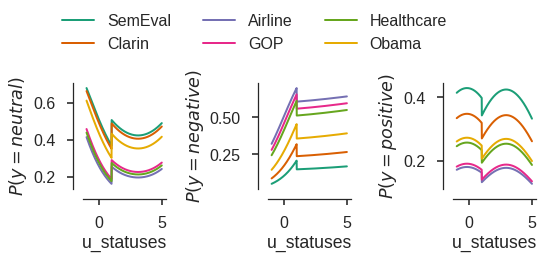

In [8]:
with sns.color_palette("Dark2", 8):
    fig, ax = plt.subplots(1,3, figsize=(8,3))
    for i, label in enumerate(labels):
        feature = "u_statuses"
        formula = (("{label} "
                    "~ I({feature}>1)*{feature} + I({feature}**2)").format(
            feature=feature, label=label
        ))
        print formula
        df_t = df.assign(**{
                    feature: lambda x: np.log10((x[feature]+1)),
                    "%s" % label: lambda x: (x["label"] == label)* 1.
                })
        base_model = sm.Logit.from_formula(
            formula, data=df_t).fit()
        display(base_model.summary2())
        model = sm.Logit.from_formula(
            "%s + %s" % (formula, "C(dataset, levels=datasets)"),
            data=df_t).fit()
        display(model.summary2())
        plot_feature(model, datasets, ax[i], lw=2)

    ax[-1].legend(bbox_to_anchor=(0.1, 1.8), ncol=3)
    sns.despine(offset=10)
    fig.tight_layout()            

## Effect of friends

neutral ~ I(u_friends>3)*u_friends + I(u_friends**2)
Optimization terminated successfully.
         Current function value: 0.671224
         Iterations 4


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                  Results: Logit
===================================================================================
Model:                     Logit                 Pseudo R-squared:      0.004      
Dependent Variable:        neutral               AIC:                   176682.9346
Date:                      2017-03-16 20:16      BIC:                   176731.8724
No. Observations:          131605                Log-Likelihood:        -88336.    
Df Model:                  4                     LL-Null:               -88705.    
Df Residuals:              131600                LLR p-value:           3.3930e-158
Converged:                 1.0000                Scale:                 1.0000     
No. Iterations:            4.0000                                                  
-----------------------------------------------------------------------------------
                                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------
Intercept                           0.6943   0.0449  15.4604 0.0000  0.6063  0.7824
I(u_friends > 3)[T.True]            1.2894   0.1683   7.6614 0.0000  0.9595  1.6193
u_friends                          -0.8890   0.0463 -19.2052 0.0000 -0.9798 -0.7983
I(u_friends > 3)[T.True]:u_friends -0.3798   0.0559  -6.7965 0.0000 -0.4893 -0.2702
I(u_friends ** 2)                   0.1690   0.0121  13.9137 0.0000  0.1452  0.1928
===================================================================================

"""

Optimization terminated successfully.
         Current function value: 0.655695
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                      Results: Logit
==========================================================================================
Model:                      Logit                    Pseudo R-squared:         0.027      
Dependent Variable:         neutral                  AIC:                      172605.5997
Date:                       2017-03-16 20:16         BIC:                      172703.4753
No. Observations:           131605                   Log-Likelihood:           -86293.    
Df Model:                   9                        LL-Null:                  -88705.    
Df Residuals:               131595                   LLR p-value:              0.0000     
Converged:                  1.0000                   Scale:                    1.0000     
No. Iterations:             5.0000                                                        
------------------------------------------------------------------------------------------
                                           Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------------------------
Intercept                                  0.7976   0.0459  17.3711 0.0000  0.7076  0.8876
I(u_friends > 3)[T.True]                   0.5799   0.1716   3.3791 0.0007  0.2436  0.9163
C(dataset, levels=datasets)[T.Clarin]     -0.0438   0.0127  -3.4447 0.0006 -0.0687 -0.0189
C(dataset, levels=datasets)[T.Airline]    -1.1268   0.0243 -46.3019 0.0000 -1.1745 -1.0791
C(dataset, levels=datasets)[T.GOP]        -0.9022   0.0252 -35.7325 0.0000 -0.9517 -0.8527
C(dataset, levels=datasets)[T.Healthcare] -0.9937   0.0523 -19.0153 0.0000 -1.0962 -0.8913
C(dataset, levels=datasets)[T.Obama]      -0.3548   0.0419  -8.4712 0.0000 -0.4369 -0.2727
u_friends                                 -0.7785   0.0470 -16.5808 0.0000 -0.8705 -0.6865
I(u_friends > 3)[T.True]:u_friends        -0.1334   0.0570  -2.3410 0.0192 -0.2451 -0.0217
I(u_friends ** 2)                          0.1376   0.0123  11.1590 0.0000  0.1135  0.1618
==========================================================================================

"""

negative ~ I(u_friends>3)*u_friends + I(u_friends**2)
Optimization terminated successfully.
         Current function value: 0.604213
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                  Results: Logit
===================================================================================
Model:                     Logit                 Pseudo R-squared:      0.002      
Dependent Variable:        negative              AIC:                   159045.0312
Date:                      2017-03-16 20:16      BIC:                   159093.9690
No. Observations:          131605                Log-Likelihood:        -79518.    
Df Model:                  4                     LL-Null:               -79666.    
Df Residuals:              131600                LLR p-value:           4.6297e-63 
Converged:                 1.0000                Scale:                 1.0000     
No. Iterations:            5.0000                                                  
-----------------------------------------------------------------------------------
                                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------
Intercept                          -1.7320   0.0566 -30.5869 0.0000 -1.8429 -1.6210
I(u_friends > 3)[T.True]           -1.5807   0.1876  -8.4275 0.0000 -1.9483 -1.2131
u_friends                           0.7218   0.0561  12.8614 0.0000  0.6118  0.8317
I(u_friends > 3)[T.True]:u_friends  0.4908   0.0622   7.8909 0.0000  0.3689  0.6127
I(u_friends ** 2)                  -0.1449   0.0142 -10.2079 0.0000 -0.1727 -0.1171
===================================================================================

"""

Optimization terminated successfully.
         Current function value: 0.549452
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                      Results: Logit
==========================================================================================
Model:                      Logit                    Pseudo R-squared:         0.092      
Dependent Variable:         negative                 AIC:                      144641.1702
Date:                       2017-03-16 20:16         BIC:                      144739.0458
No. Observations:           131605                   Log-Likelihood:           -72311.    
Df Model:                   9                        LL-Null:                  -79666.    
Df Residuals:               131595                   LLR p-value:              0.0000     
Converged:                  1.0000                   Scale:                    1.0000     
No. Iterations:             6.0000                                                        
------------------------------------------------------------------------------------------
                                           Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------------------------
Intercept                                 -2.2547   0.0605 -37.2594 0.0000 -2.3733 -2.1361
I(u_friends > 3)[T.True]                  -0.2193   0.2001  -1.0961 0.2730 -0.6114  0.1728
C(dataset, levels=datasets)[T.Clarin]      0.5723   0.0160  35.7541 0.0000  0.5409  0.6036
C(dataset, levels=datasets)[T.Airline]     2.1354   0.0229  93.4399 0.0000  2.0906  2.1802
C(dataset, levels=datasets)[T.GOP]         2.0037   0.0245  81.8720 0.0000  1.9558  2.0517
C(dataset, levels=datasets)[T.Healthcare]  1.9008   0.0469  40.5651 0.0000  1.8090  1.9927
C(dataset, levels=datasets)[T.Obama]       1.1968   0.0427  28.0550 0.0000  1.1132  1.2804
u_friends                                  0.4822   0.0593   8.1314 0.0000  0.3660  0.5985
I(u_friends > 3)[T.True]:u_friends         0.0152   0.0663   0.2297 0.8183 -0.1147  0.1452
I(u_friends ** 2)                         -0.0819   0.0150  -5.4496 0.0000 -0.1113 -0.0524
==========================================================================================

"""

positive ~ I(u_friends>3)*u_friends + I(u_friends**2)
Optimization terminated successfully.
         Current function value: 0.613285
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                  Results: Logit
===================================================================================
Model:                     Logit                 Pseudo R-squared:      0.001      
Dependent Variable:        positive              AIC:                   161432.6192
Date:                      2017-03-16 20:16      BIC:                   161481.5570
No. Observations:          131605                Log-Likelihood:        -80711.    
Df Model:                  4                     LL-Null:               -80820.    
Df Residuals:              131600                LLR p-value:           8.2869e-46 
Converged:                 1.0000                Scale:                 1.0000     
No. Iterations:            5.0000                                                  
-----------------------------------------------------------------------------------
                                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------
Intercept                          -1.4415   0.0529 -27.2338 0.0000 -1.5452 -1.3378
I(u_friends > 3)[T.True]           -0.2249   0.1840  -1.2220 0.2217 -0.5856  0.1358
u_friends                           0.4884   0.0532   9.1836 0.0000  0.3842  0.5927
I(u_friends > 3)[T.True]:u_friends  0.0541   0.0610   0.8866 0.3753 -0.0654  0.1736
I(u_friends ** 2)                  -0.0897   0.0136  -6.5790 0.0000 -0.1164 -0.0630
===================================================================================

"""

Optimization terminated successfully.
         Current function value: 0.599048
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                      Results: Logit
==========================================================================================
Model:                      Logit                    Pseudo R-squared:         0.025      
Dependent Variable:         positive                 AIC:                      157695.5328
Date:                       2017-03-16 20:16         BIC:                      157793.4084
No. Observations:           131605                   Log-Likelihood:           -78838.    
Df Model:                   9                        LL-Null:                  -80820.    
Df Residuals:               131595                   LLR p-value:              0.0000     
Converged:                  1.0000                   Scale:                    1.0000     
No. Iterations:             6.0000                                                        
------------------------------------------------------------------------------------------
                                           Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------------------------
Intercept                                 -1.2261   0.0534 -22.9400 0.0000 -1.3309 -1.1213
I(u_friends > 3)[T.True]                  -0.7741   0.1869  -4.1412 0.0000 -1.1405 -0.4077
C(dataset, levels=datasets)[T.Clarin]     -0.3690   0.0133 -27.8032 0.0000 -0.3950 -0.3430
C(dataset, levels=datasets)[T.Airline]    -1.1504   0.0263 -43.7883 0.0000 -1.2019 -1.0989
C(dataset, levels=datasets)[T.GOP]        -1.1870   0.0290 -40.8673 0.0000 -1.2439 -1.1301
C(dataset, levels=datasets)[T.Healthcare] -0.8642   0.0551 -15.6743 0.0000 -0.9723 -0.7562
C(dataset, levels=datasets)[T.Obama]      -0.6664   0.0470 -14.1822 0.0000 -0.7585 -0.5743
u_friends                                  0.6179   0.0536  11.5315 0.0000  0.5128  0.7229
I(u_friends > 3)[T.True]:u_friends         0.2412   0.0619   3.8944 0.0001  0.1198  0.3626
I(u_friends ** 2)                         -0.1186   0.0138  -8.6168 0.0000 -0.1456 -0.0917
==========================================================================================

"""

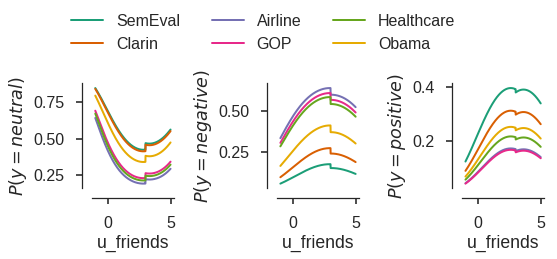

In [9]:
with sns.color_palette("Dark2", 8):
    fig, ax = plt.subplots(1,3, figsize=(8,3))
    
    for i, label in enumerate(labels):
        feature = "u_friends"
        formula = (("{label} "
                    "~ I({feature}>3)*{feature} + I({feature}**2)").format(
            feature=feature, label=label
        ))
        print formula
        df_t = df.assign(**{
                    feature: lambda x: np.log10((x[feature]+1)),
                    "%s" % label: lambda x: (x["label"] == label)* 1.
                })
        base_model = sm.Logit.from_formula(
            formula, data=df_t).fit()
        display(base_model.summary2())
        model = sm.Logit.from_formula(
            "%s + %s" % (formula, "+ C(dataset, levels=datasets)"),
            data=df_t).fit()
        display(model.summary2())
        plot_feature(model, datasets, ax[i], lw=2)

    ax[-1].legend(bbox_to_anchor=(0.1, 1.8), ncol=3)
    sns.despine(offset=10)
    fig.tight_layout()            

## Effect of statuses_followers

neutral ~ statuses_followers + I(statuses_followers**2)
Optimization terminated successfully.
         Current function value: 0.668837
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
===========================================================================
Model:                 Logit               Pseudo R-squared:    0.008      
Dependent Variable:    neutral             AIC:                 176050.5715
Date:                  2017-03-16 20:16    BIC:                 176079.9342
No. Observations:      131605              Log-Likelihood:      -88022.    
Df Model:              2                   LL-Null:             -88705.    
Df Residuals:          131602              LLR p-value:         3.2785e-297
Converged:             1.0000              Scale:               1.0000     
No. Iterations:        5.0000                                              
---------------------------------------------------------------------------
                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
Intercept                  -0.1982   0.0200  -9.9009 0.0000 -0.2375 -0.1590
statuses_followers         -0.5976   0.0292 -20.4545 0.0000 -0.6549 -0.5403
I(statuses_followers ** 2)  0.2854   0.0102  28.0034 0.0000  0.2655  0.3054
===========================================================================

"""

Optimization terminated successfully.
         Current function value: 0.654324
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                      Results: Logit
==========================================================================================
Model:                      Logit                    Pseudo R-squared:         0.029      
Dependent Variable:         neutral                  AIC:                      172240.6631
Date:                       2017-03-16 20:16         BIC:                      172318.9636
No. Observations:           131605                   Log-Likelihood:           -86112.    
Df Model:                   7                        LL-Null:                  -88705.    
Df Residuals:               131597                   LLR p-value:              0.0000     
Converged:                  1.0000                   Scale:                    1.0000     
No. Iterations:             5.0000                                                        
------------------------------------------------------------------------------------------
                                           Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------------------------
Intercept                                  0.1648   0.0218   7.5519 0.0000  0.1220  0.2075
C(dataset, levels=datasets)[T.Clarin]     -0.0480   0.0128  -3.7467 0.0002 -0.0731 -0.0229
C(dataset, levels=datasets)[T.Airline]    -1.1245   0.0245 -45.9143 0.0000 -1.1725 -1.0765
C(dataset, levels=datasets)[T.GOP]        -0.8642   0.0250 -34.5160 0.0000 -0.9133 -0.8151
C(dataset, levels=datasets)[T.Healthcare] -0.9716   0.0517 -18.8083 0.0000 -1.0729 -0.8704
C(dataset, levels=datasets)[T.Obama]      -0.2876   0.0418  -6.8893 0.0000 -0.3695 -0.2058
statuses_followers                        -0.7583   0.0300 -25.3102 0.0000 -0.8170 -0.6996
I(statuses_followers ** 2)                 0.3026   0.0103  29.4138 0.0000  0.2825  0.3228
==========================================================================================

"""

negative ~ statuses_followers + I(statuses_followers**2)
Optimization terminated successfully.
         Current function value: 0.602527
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
===========================================================================
Model:                 Logit               Pseudo R-squared:    0.005      
Dependent Variable:    negative            AIC:                 158597.1771
Date:                  2017-03-16 20:16    BIC:                 158626.5398
No. Observations:      131605              Log-Likelihood:      -79296.    
Df Model:              2                   LL-Null:             -79666.    
Df Residuals:          131602              LLR p-value:         1.2856e-161
Converged:             1.0000              Scale:               1.0000     
No. Iterations:        6.0000                                              
---------------------------------------------------------------------------
                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
Intercept                  -1.2106   0.0231 -52.4239 0.0000 -1.2559 -1.1653
statuses_followers          0.7227   0.0352  20.5373 0.0000  0.6537  0.7917
I(statuses_followers ** 2) -0.3010   0.0129 -23.3573 0.0000 -0.3262 -0.2757
===========================================================================

"""

Optimization terminated successfully.
         Current function value: 0.547008
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                      Results: Logit
==========================================================================================
Model:                      Logit                    Pseudo R-squared:         0.096      
Dependent Variable:         negative                 AIC:                      143993.9078
Date:                       2017-03-16 20:16         BIC:                      144072.2083
No. Observations:           131605                   Log-Likelihood:           -71989.    
Df Model:                   7                        LL-Null:                  -79666.    
Df Residuals:               131597                   LLR p-value:              0.0000     
Converged:                  1.0000                   Scale:                    1.0000     
No. Iterations:             6.0000                                                        
------------------------------------------------------------------------------------------
                                           Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------------------------
Intercept                                 -2.3296   0.0282 -82.6160 0.0000 -2.3849 -2.2744
C(dataset, levels=datasets)[T.Clarin]      0.5409   0.0161  33.6189 0.0000  0.5094  0.5725
C(dataset, levels=datasets)[T.Airline]     2.2171   0.0233  94.9828 0.0000  2.1713  2.2628
C(dataset, levels=datasets)[T.GOP]         1.9638   0.0242  81.0498 0.0000  1.9163  2.0113
C(dataset, levels=datasets)[T.Healthcare]  1.9874   0.0465  42.7394 0.0000  1.8962  2.0785
C(dataset, levels=datasets)[T.Obama]       1.2131   0.0428  28.3514 0.0000  1.1293  1.2970
statuses_followers                         1.0610   0.0376  28.1965 0.0000  0.9872  1.1347
I(statuses_followers ** 2)                -0.3292   0.0132 -24.8928 0.0000 -0.3551 -0.3033
==========================================================================================

"""

positive ~ statuses_followers + I(statuses_followers**2)
Optimization terminated successfully.
         Current function value: 0.612931
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
===========================================================================
Model:                 Logit               Pseudo R-squared:    0.002      
Dependent Variable:    positive            AIC:                 161335.5044
Date:                  2017-03-16 20:16    BIC:                 161364.8671
No. Observations:      131605              Log-Likelihood:      -80665.    
Df Model:              2                   LL-Null:             -80820.    
Df Residuals:          131602              LLR p-value:         4.5641e-68 
Converged:             1.0000              Scale:               1.0000     
No. Iterations:        5.0000                                              
---------------------------------------------------------------------------
                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
Intercept                  -0.8003   0.0211 -37.9909 0.0000 -0.8416 -0.7590
statuses_followers          0.1328   0.0306   4.3336 0.0000  0.0727  0.1928
I(statuses_followers ** 2) -0.1020   0.0107  -9.5100 0.0000 -0.1230 -0.0810
===========================================================================

"""

Optimization terminated successfully.
         Current function value: 0.597727
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                      Results: Logit
==========================================================================================
Model:                      Logit                    Pseudo R-squared:         0.027      
Dependent Variable:         positive                 AIC:                      157343.6462
Date:                       2017-03-16 20:16         BIC:                      157421.9467
No. Observations:           131605                   Log-Likelihood:           -78664.    
Df Model:                   7                        LL-Null:                  -80820.    
Df Residuals:               131597                   LLR p-value:              0.0000     
Converged:                  1.0000                   Scale:                    1.0000     
No. Iterations:             6.0000                                                        
------------------------------------------------------------------------------------------
                                           Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------------------------
Intercept                                 -0.3466   0.0229 -15.1673 0.0000 -0.3914 -0.3019
C(dataset, levels=datasets)[T.Clarin]     -0.3359   0.0134 -25.1089 0.0000 -0.3621 -0.3097
C(dataset, levels=datasets)[T.Airline]    -1.2117   0.0264 -45.8368 0.0000 -1.2635 -1.1599
C(dataset, levels=datasets)[T.GOP]        -1.1891   0.0289 -41.1584 0.0000 -1.2457 -1.1324
C(dataset, levels=datasets)[T.Healthcare] -0.9424   0.0545 -17.2900 0.0000 -1.0492 -0.8356
C(dataset, levels=datasets)[T.Obama]      -0.7487   0.0469 -15.9480 0.0000 -0.8407 -0.6567
statuses_followers                         0.0680   0.0320   2.1254 0.0336  0.0053  0.1307
I(statuses_followers ** 2)                -0.1098   0.0112  -9.8264 0.0000 -0.1317 -0.0879
==========================================================================================

"""

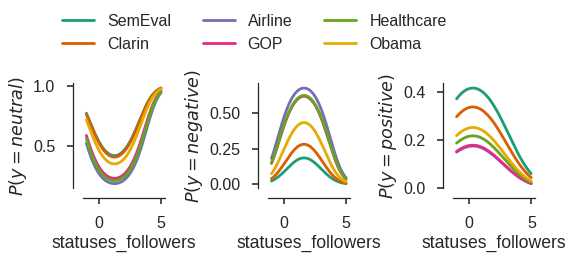

In [10]:
with sns.color_palette("Dark2", 8):
    fig, ax = plt.subplots(1,3, figsize=(8,3))
    
    for i, label in enumerate(labels):
        feature = "statuses_followers"
        formula = (("{label} "
                    "~ {feature} + I({feature}**2)").format(
            feature=feature, label=label
        ))
        print formula
        df_t = df.assign(**{
                    feature: lambda x: np.log10((x[feature]+1)),
                    "%s" % label: lambda x: (x["label"] == label)* 1.
                })
        base_model = sm.Logit.from_formula(
            formula, data=df_t).fit()
        display(base_model.summary2())
        model = sm.Logit.from_formula(
            "%s + %s" % (formula, "+ C(dataset, levels=datasets)"),
            data=df_t).fit()
        display(model.summary2())
        plot_feature(model, datasets, ax[i])

    ax[-1].legend(bbox_to_anchor=(0.1, 1.8), ncol=3)
    sns.despine(offset=10)
    fig.tight_layout()        

## Effect of statuses_friends

neutral ~ I(statuses_friends>2.5)*(statuses_friends + I(statuses_friends**2))
Optimization terminated successfully.
         Current function value: 0.667921
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                              Results: Logit
===========================================================================================================
Model:                             Logit                         Pseudo R-squared:              0.009      
Dependent Variable:                neutral                       AIC:                           175815.5879
Date:                              2017-03-16 20:16              BIC:                           175874.3133
No. Observations:                  131605                        Log-Likelihood:                -87902.    
Df Model:                          5                             LL-Null:                       -88705.    
Df Residuals:                      131599                        LLR p-value:                   0.0000     
Converged:                         1.0000                        Scale:                         1.0000     
No. Iterations:                    5.0000                                                                  
-----------------------------------------------------------------------------------------------------------
                                                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                                  -0.5745   0.0246 -23.3386 0.0000 -0.6227 -0.5262
I(statuses_friends > 2.5)[T.True]                          -2.2183   0.4428  -5.0097 0.0000 -3.0862 -1.3504
statuses_friends                                            0.0169   0.0412   0.4096 0.6821 -0.0639  0.0976
I(statuses_friends > 2.5)[T.True]:statuses_friends          1.2720   0.2493   5.1028 0.0000  0.7834  1.7605
I(statuses_friends ** 2)                                    0.0544   0.0157   3.4543 0.0006  0.0235  0.0852
I(statuses_friends > 2.5)[T.True]:I(statuses_friends ** 2) -0.1570   0.0360  -4.3641 0.0000 -0.2275 -0.0865
===========================================================================================================

"""

Optimization terminated successfully.
         Current function value: 0.654597
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                              Results: Logit
===========================================================================================================
Model:                             Logit                         Pseudo R-squared:              0.029      
Dependent Variable:                neutral                       AIC:                           172318.3536
Date:                              2017-03-16 20:16              BIC:                           172426.0168
No. Observations:                  131605                        Log-Likelihood:                -86148.    
Df Model:                          10                            LL-Null:                       -88705.    
Df Residuals:                      131594                        LLR p-value:                   0.0000     
Converged:                         1.0000                        Scale:                         1.0000     
No. Iterations:                    5.0000                                                                  
-----------------------------------------------------------------------------------------------------------
                                                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                                  -0.1127   0.0269  -4.1847 0.0000 -0.1655 -0.0599
I(statuses_friends > 2.5)[T.True]                          -2.4920   0.4444  -5.6075 0.0000 -3.3630 -1.6210
C(dataset, levels=datasets)[T.Clarin]                      -0.0521   0.0127  -4.0889 0.0000 -0.0771 -0.0271
C(dataset, levels=datasets)[T.Airline]                     -1.1066   0.0249 -44.4074 0.0000 -1.1555 -1.0578
C(dataset, levels=datasets)[T.GOP]                         -0.8543   0.0251 -34.0500 0.0000 -0.9035 -0.8052
C(dataset, levels=datasets)[T.Healthcare]                  -0.8759   0.0513 -17.0839 0.0000 -0.9764 -0.7754
C(dataset, levels=datasets)[T.Obama]                       -0.2532   0.0417  -6.0699 0.0000 -0.3349 -0.1714
statuses_friends                                           -0.2675   0.0425  -6.3001 0.0000 -0.3507 -0.1843
I(statuses_friends > 2.5)[T.True]:statuses_friends          1.5146   0.2502   6.0526 0.0000  1.0241  2.0050
I(statuses_friends ** 2)                                    0.1068   0.0161   6.6462 0.0000  0.0753  0.1383
I(statuses_friends > 2.5)[T.True]:I(statuses_friends ** 2) -0.2069   0.0362  -5.7161 0.0000 -0.2779 -0.1360
===========================================================================================================

"""

negative ~ I(statuses_friends>2.5)*(statuses_friends + I(statuses_friends**2))
Optimization terminated successfully.
         Current function value: 0.602467
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                              Results: Logit
===========================================================================================================
Model:                             Logit                         Pseudo R-squared:              0.005      
Dependent Variable:                negative                      AIC:                           158587.3459
Date:                              2017-03-16 20:16              BIC:                           158646.0712
No. Observations:                  131605                        Log-Likelihood:                -79288.    
Df Model:                          5                             LL-Null:                       -79666.    
Df Residuals:                      131599                        LLR p-value:                   2.6084e-161
Converged:                         1.0000                        Scale:                         1.0000     
No. Iterations:                    6.0000                                                                  
-----------------------------------------------------------------------------------------------------------
                                                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                                  -0.6545   0.0254 -25.7378 0.0000 -0.7044 -0.6047
I(statuses_friends > 2.5)[T.True]                           1.3129   0.5654   2.3222 0.0202  0.2048  2.4210
statuses_friends                                           -0.1738   0.0433  -4.0155 0.0001 -0.2586 -0.0890
I(statuses_friends > 2.5)[T.True]:statuses_friends         -0.6991   0.3199  -2.1855 0.0289 -1.3261 -0.0721
I(statuses_friends ** 2)                                    0.0168   0.0167   1.0020 0.3163 -0.0160  0.0496
I(statuses_friends > 2.5)[T.True]:I(statuses_friends ** 2)  0.0499   0.0453   1.1021 0.2704 -0.0389  0.1387
===========================================================================================================

"""

Optimization terminated successfully.
         Current function value: 0.548707
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                              Results: Logit
===========================================================================================================
Model:                             Logit                         Pseudo R-squared:              0.094      
Dependent Variable:                negative                      AIC:                           144447.1393
Date:                              2017-03-16 20:16              BIC:                           144554.8025
No. Observations:                  131605                        Log-Likelihood:                -72213.    
Df Model:                          10                            LL-Null:                       -79666.    
Df Residuals:                      131594                        LLR p-value:                   0.0000     
Converged:                         1.0000                        Scale:                         1.0000     
No. Iterations:                    6.0000                                                                  
-----------------------------------------------------------------------------------------------------------
                                                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                                  -1.9746   0.0316 -62.5772 0.0000 -2.0364 -1.9128
I(statuses_friends > 2.5)[T.True]                           1.7174   0.5734   2.9952 0.0027  0.5936  2.8412
C(dataset, levels=datasets)[T.Clarin]                       0.5624   0.0160  35.0831 0.0000  0.5310  0.5939
C(dataset, levels=datasets)[T.Airline]                      2.2332   0.0239  93.5540 0.0000  2.1865  2.2800
C(dataset, levels=datasets)[T.GOP]                          1.9920   0.0243  81.9655 0.0000  1.9444  2.0397
C(dataset, levels=datasets)[T.Healthcare]                   1.8344   0.0456  40.2072 0.0000  1.7450  1.9238
C(dataset, levels=datasets)[T.Obama]                        1.1748   0.0426  27.5589 0.0000  1.0912  1.2583
statuses_friends                                            0.3902   0.0477   8.1866 0.0000  0.2968  0.4836
I(statuses_friends > 2.5)[T.True]:statuses_friends         -1.0768   0.3241  -3.3228 0.0009 -1.7119 -0.4416
I(statuses_friends ** 2)                                   -0.0732   0.0180  -4.0578 0.0000 -0.1085 -0.0378
I(statuses_friends > 2.5)[T.True]:I(statuses_friends ** 2)  0.1245   0.0461   2.7015 0.0069  0.0342  0.2149
===========================================================================================================

"""

positive ~ I(statuses_friends>2.5)*(statuses_friends + I(statuses_friends**2))
Optimization terminated successfully.
         Current function value: 0.612709
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                              Results: Logit
===========================================================================================================
Model:                             Logit                         Pseudo R-squared:              0.002      
Dependent Variable:                positive                      AIC:                           161283.1729
Date:                              2017-03-16 20:16              BIC:                           161341.8983
No. Observations:                  131605                        Log-Likelihood:                -80636.    
Df Model:                          5                             LL-Null:                       -80820.    
Df Residuals:                      131599                        LLR p-value:                   1.8653e-77 
Converged:                         1.0000                        Scale:                         1.0000     
No. Iterations:                    6.0000                                                                  
-----------------------------------------------------------------------------------------------------------
                                                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                                  -0.8590   0.0258 -33.2561 0.0000 -0.9096 -0.8083
I(statuses_friends > 2.5)[T.True]                           1.7012   0.5260   3.2344 0.0012  0.6703  2.7320
statuses_friends                                            0.1701   0.0436   3.9030 0.0001  0.0847  0.2555
I(statuses_friends > 2.5)[T.True]:statuses_friends         -0.9592   0.2981  -3.2175 0.0013 -1.5435 -0.3749
I(statuses_friends ** 2)                                   -0.0844   0.0168  -5.0350 0.0000 -0.1173 -0.0516
I(statuses_friends > 2.5)[T.True]:I(statuses_friends ** 2)  0.1355   0.0426   3.1784 0.0015  0.0520  0.2191
===========================================================================================================

"""

Optimization terminated successfully.
         Current function value: 0.596969
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                              Results: Logit
===========================================================================================================
Model:                             Logit                         Pseudo R-squared:              0.028      
Dependent Variable:                positive                      AIC:                           157150.1501
Date:                              2017-03-16 20:16              BIC:                           157257.8133
No. Observations:                  131605                        Log-Likelihood:                -78564.    
Df Model:                          10                            LL-Null:                       -80820.    
Df Residuals:                      131594                        LLR p-value:                   0.0000     
Converged:                         1.0000                        Scale:                         1.0000     
No. Iterations:                    6.0000                                                                  
-----------------------------------------------------------------------------------------------------------
                                                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                                  -0.2572   0.0282  -9.1338 0.0000 -0.3123 -0.2020
I(statuses_friends > 2.5)[T.True]                           1.6640   0.5308   3.1347 0.0017  0.6236  2.7044
C(dataset, levels=datasets)[T.Clarin]                      -0.3514   0.0133 -26.3840 0.0000 -0.3775 -0.3253
C(dataset, levels=datasets)[T.Airline]                     -1.2570   0.0269 -46.6750 0.0000 -1.3098 -1.2042
C(dataset, levels=datasets)[T.GOP]                         -1.2293   0.0290 -42.4404 0.0000 -1.2860 -1.1725
C(dataset, levels=datasets)[T.Healthcare]                  -0.9337   0.0543 -17.1964 0.0000 -1.0401 -0.8273
C(dataset, levels=datasets)[T.Obama]                       -0.7583   0.0470 -16.1495 0.0000 -0.8504 -0.6663
statuses_friends                                           -0.0557   0.0449  -1.2392 0.2153 -0.1437  0.0324
I(statuses_friends > 2.5)[T.True]:statuses_friends         -0.8864   0.3010  -2.9447 0.0032 -1.4765 -0.2964
I(statuses_friends ** 2)                                   -0.0501   0.0171  -2.9235 0.0035 -0.0837 -0.0165
I(statuses_friends > 2.5)[T.True]:I(statuses_friends ** 2)  0.1165   0.0431   2.7010 0.0069  0.0320  0.2010
===========================================================================================================

"""

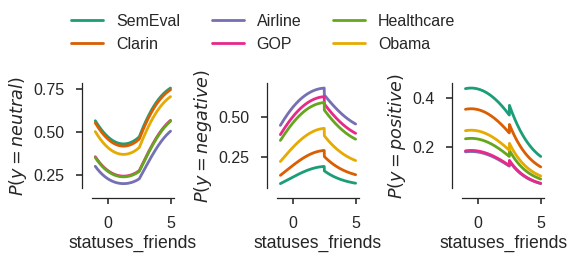

In [11]:
with sns.color_palette("Dark2", 8):
    fig, ax = plt.subplots(1,3, figsize=(8,3))
    
    for i, label in enumerate(labels):
        feature = "statuses_friends"
        formula = (("{label} "
                    "~ I({feature}>2.5)*({feature} + I({feature}**2))").format(
            feature=feature, label=label
        ))
        print formula
        df_t = df.assign(**{
                    feature: lambda x: np.log10((x[feature]+1)),
                    "%s" % label: lambda x: (x["label"] == label)* 1.
                })
        base_model = sm.Logit.from_formula(
            formula, data=df_t).fit()
        display(base_model.summary2())
        model = sm.Logit.from_formula(
            "%s + %s" % (formula, "+ C(dataset, levels=datasets)"),
            data=df_t).fit()
        display(model.summary2())
        plot_feature(model, datasets, ax[i])

    ax[-1].legend(bbox_to_anchor=(0.1, 1.8), ncol=3)
    sns.despine(offset=10)
    fig.tight_layout()    

## User meta models

In [12]:
for label in ["neutral", "negative",  "positive"]:
    formula = ("is_%s ~ u_statuses + I(u_statuses**2)"
               "+ u_followers + I(u_followers**2)"
               "+ u_friends + I(u_friends**2)"
               "+ user_age"
               "+ u_verified + u_has_url"
              ) % label
    model = sm.Logit.from_formula(formula, df.assign(**{
            "is_%s" % label: lambda x: (x.label == label)* 1.,
            "u_statuses": lambda x: np.log10(x["u_statuses"] + 1),
            "u_followers": lambda x: np.log10(x["u_followers"] + 1),
            "u_friends": lambda x: np.log10(x["u_friends"] + 1),
            "user_age": lambda x: np.log10(x["user_age"] + 1),
            }      
        ))
    print label
    res = model.fit()
    display(res.summary2())

neutral
Optimization terminated successfully.
         Current function value: 0.665848
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
====================================================================
Model:                Logit            Pseudo R-squared: 0.012      
Dependent Variable:   is_neutral       AIC:              175277.7236
Date:                 2017-03-16 20:16 BIC:              175375.5992
No. Observations:     131605           Log-Likelihood:   -87629.    
Df Model:             9                LL-Null:          -88705.    
Df Residuals:         131595           LLR p-value:      0.0000     
Converged:            1.0000           Scale:            1.0000     
No. Iterations:       5.0000                                        
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
Intercept            0.0248   0.0713   0.3471 0.7285 -0.1151  0.1646
u_verified[T.True]   0.2589   0.0392   6.6079 0.0000  0.1821  0.3357
u_has_url[T.True]    0.2176   0.0123  17.7541 0.0000  0.1936  0.2417
u_statuses           0.3083   0.0425   7.2478 0.0000  0.2249  0.3916
I(u_statuses ** 2)  -0.0076   0.0055  -1.3956 0.1628 -0.0184  0.0031
u_followers         -0.0870   0.0378  -2.2986 0.0215 -0.1612 -0.0128
I(u_followers ** 2)  0.0085   0.0059   1.4307 0.1525 -0.0031  0.0201
u_friends           -0.6016   0.0356 -16.9202 0.0000 -0.6713 -0.5320
I(u_friends ** 2)    0.0828   0.0070  11.8526 0.0000  0.0691  0.0965
user_age            -0.1685   0.0114 -14.8102 0.0000 -0.1908 -0.1462
====================================================================

"""

negative
Optimization terminated successfully.
         Current function value: 0.596405
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
====================================================================
Model:                Logit            Pseudo R-squared: 0.015      
Dependent Variable:   is_negative      AIC:              156999.8759
Date:                 2017-03-16 20:16 BIC:              157097.7515
No. Observations:     131605           Log-Likelihood:   -78490.    
Df Model:             9                LL-Null:          -79666.    
Df Residuals:         131595           LLR p-value:      0.0000     
Converged:            1.0000           Scale:            1.0000     
No. Iterations:       5.0000                                        
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
Intercept           -0.7896   0.0748 -10.5558 0.0000 -0.9362 -0.6430
u_verified[T.True]  -0.1102   0.0455  -2.4221 0.0154 -0.1994 -0.0210
u_has_url[T.True]   -0.3245   0.0135 -24.0970 0.0000 -0.3509 -0.2981
u_statuses          -0.7487   0.0442 -16.9309 0.0000 -0.8354 -0.6620
I(u_statuses ** 2)   0.0806   0.0058  13.9815 0.0000  0.0693  0.0919
u_followers         -0.1053   0.0434  -2.4282 0.0152 -0.1903 -0.0203
I(u_followers ** 2)  0.0027   0.0069   0.3879 0.6981 -0.0108  0.0162
u_friends            0.5082   0.0441  11.5338 0.0000  0.4218  0.5945
I(u_friends ** 2)   -0.0511   0.0084  -6.0733 0.0000 -0.0676 -0.0346
user_age             0.3445   0.0130  26.5158 0.0000  0.3191  0.3700
====================================================================

"""

positive
Optimization terminated successfully.
         Current function value: 0.611127
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
====================================================================
Model:                Logit            Pseudo R-squared: 0.005      
Dependent Variable:   is_positive      AIC:              160874.7863
Date:                 2017-03-16 20:16 BIC:              160972.6619
No. Observations:     131605           Log-Likelihood:   -80427.    
Df Model:             9                LL-Null:          -80820.    
Df Residuals:         131595           LLR p-value:      3.9083e-163
Converged:            1.0000           Scale:            1.0000     
No. Iterations:       5.0000                                        
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
Intercept           -1.7838   0.0803 -22.2116 0.0000 -1.9412 -1.6264
u_verified[T.True]  -0.2142   0.0431  -4.9666 0.0000 -0.2988 -0.1297
u_has_url[T.True]    0.0653   0.0130   5.0121 0.0000  0.0397  0.0908
u_statuses           0.4717   0.0471  10.0049 0.0000  0.3793  0.5641
I(u_statuses ** 2)  -0.0813   0.0061 -13.2783 0.0000 -0.0932 -0.0693
u_followers          0.1659   0.0415   3.9953 0.0001  0.0845  0.2472
I(u_followers ** 2) -0.0076   0.0065  -1.1695 0.2422 -0.0204  0.0051
u_friends            0.3358   0.0403   8.3237 0.0000  0.2568  0.4149
I(u_friends ** 2)   -0.0676   0.0079  -8.5630 0.0000 -0.0831 -0.0521
user_age            -0.1337   0.0119 -11.1967 0.0000 -0.1571 -0.1103
====================================================================

"""

## Tweet meta data

In [13]:
for label in ["neutral", "negative", "positive"]:
    formula = ("is_%s ~ n_mentions + n_urls + n_hashtags"
               "+ is_reply + is_quote"
              ) % label
    model = sm.Logit.from_formula(formula, df.assign(**{
            "is_%s" % label: lambda x: (x.label == label)* 1.,
            "n_mentions": lambda x: np.log10(x["n_mentions"] + 1),
            "n_urls": lambda x: np.log10(x["n_urls"] + 1),
            "n_hashtags": lambda x: np.log10(x["n_hashtags"] + 1),
            }      
        ))

    res = model.fit()
    display(res.summary2())

Optimization terminated successfully.
         Current function value: 0.655649
         Iterations 4


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.027      
Dependent Variable: is_neutral       AIC:              172585.3366
Date:               2017-03-16 20:16 BIC:              172644.0620
No. Observations:   131605           Log-Likelihood:   -86287.    
Df Model:           5                LL-Null:          -88705.    
Df Residuals:       131599           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     4.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
Intercept         -0.5590   0.0094 -59.6356 0.0000 -0.5774 -0.5406
is_reply[T.True]   0.0500   0.0163   3.0602 0.0022  0.0180  0.0820
is_quote[T.True]  -0.7472   0.0467 -16.0002 0.0000 -0.8388 -0.6557
n_mentions        -0.0683   0.0335  -2.0376 0.0416 -0.1340 -0.0026
n_urls             3.3534   0.0500  67.0322 0.0000  3.2554  3.4515
n_hashtags        -0.2216   0.0315  -7.0312 0.0000 -0.2834 -0.1598
==================================================================

"""

Optimization terminated successfully.
         Current function value: 0.586321
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.031      
Dependent Variable: is_negative      AIC:              154337.4775
Date:               2017-03-16 20:16 BIC:              154396.2029
No. Observations:   131605           Log-Likelihood:   -77163.    
Df Model:           5                LL-Null:          -79666.    
Df Residuals:       131599           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
Intercept         -0.8505   0.0100 -85.3225 0.0000 -0.8700 -0.8310
is_reply[T.True]   0.0452   0.0169   2.6704 0.0076  0.0120  0.0783
is_quote[T.True]   1.1750   0.0513  22.9085 0.0000  1.0745  1.2755
n_mentions         0.3034   0.0356   8.5178 0.0000  0.2336  0.3733
n_urls            -4.0872   0.0699 -58.4709 0.0000 -4.2242 -3.9502
n_hashtags         0.7322   0.0333  21.9932 0.0000  0.6670  0.7975
==================================================================

"""

Optimization terminated successfully.
         Current function value: 0.612340
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.003      
Dependent Variable: is_positive      AIC:              161186.0684
Date:               2017-03-16 20:16 BIC:              161244.7938
No. Observations:   131605           Log-Likelihood:   -80587.    
Df Model:           5                LL-Null:          -80820.    
Df Residuals:       131599           LLR p-value:      2.1699e-98 
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     5.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
Intercept         -0.6854   0.0097 -70.7202 0.0000 -0.7044 -0.6664
is_reply[T.True]  -0.0965   0.0172  -5.6095 0.0000 -0.1303 -0.0628
is_quote[T.True]  -0.0506   0.0519  -0.9739 0.3301 -0.1523  0.0512
n_mentions        -0.2197   0.0353  -6.2317 0.0000 -0.2889 -0.1506
n_urls            -0.7281   0.0541 -13.4480 0.0000 -0.8342 -0.6220
n_hashtags        -0.4670   0.0339 -13.7609 0.0000 -0.5336 -0.4005
==================================================================

"""

## Joint meta data model

In [14]:
for label in ["neutral", "negative",  "positive"]:
    formula = ("is_%s ~ u_statuses + I(u_statuses**2)"
               "+ u_followers + I(u_followers**2)"
               "+ u_friends + I(u_friends**2)"
               "+ user_age"
               "+ u_verified + u_has_url"
               "+ n_mentions + n_urls + n_hashtags"
               "+ is_reply + is_quote"
              ) % label
    model = sm.Logit.from_formula(formula, df.assign(**{
            "is_%s" % label: lambda x: (x.label == label)* 1.,
            "u_statuses": lambda x: np.log10(x["u_statuses"] + 1),
            "u_followers": lambda x: np.log10(x["u_followers"] + 1),
            "u_friends": lambda x: np.log10(x["u_friends"] + 1),
            "user_age": lambda x: np.log10(x["user_age"] + 1),
            "n_mentions": lambda x: np.log10(x["n_mentions"] + 1),
            "n_urls": lambda x: np.log10(x["n_urls"] + 1),
            "n_hashtags": lambda x: np.log10(x["n_hashtags"] + 1),
            }      
        ))
    print label
    res = model.fit()
    display(res.summary2())

neutral
Optimization terminated successfully.
         Current function value: 0.650635
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
====================================================================
Model:                Logit            Pseudo R-squared: 0.035      
Dependent Variable:   is_neutral       AIC:              171283.6536
Date:                 2017-03-16 20:16 BIC:              171430.4670
No. Observations:     131605           Log-Likelihood:   -85627.    
Df Model:             14               LL-Null:          -88705.    
Df Residuals:         131590           LLR p-value:      0.0000     
Converged:            1.0000           Scale:            1.0000     
No. Iterations:       5.0000                                        
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
Intercept           -0.3642   0.0737  -4.9411 0.0000 -0.5087 -0.2197
u_verified[T.True]   0.2906   0.0399   7.2770 0.0000  0.2124  0.3689
u_has_url[T.True]    0.0961   0.0127   7.5830 0.0000  0.0713  0.1210
is_reply[T.True]     0.0571   0.0164   3.4731 0.0005  0.0249  0.0893
is_quote[T.True]    -0.6837   0.0470 -14.5450 0.0000 -0.7758 -0.5916
u_statuses           0.2841   0.0436   6.5137 0.0000  0.1986  0.3695
I(u_statuses ** 2)  -0.0068   0.0056  -1.2038 0.2287 -0.0178  0.0042
u_followers         -0.0378   0.0388  -0.9747 0.3297 -0.1138  0.0382
I(u_followers ** 2)  0.0010   0.0061   0.1580 0.8745 -0.0109  0.0129
u_friends           -0.3607   0.0366  -9.8557 0.0000 -0.4324 -0.2890
I(u_friends ** 2)    0.0442   0.0072   6.1491 0.0000  0.0301  0.0583
user_age            -0.1977   0.0116 -17.0588 0.0000 -0.2204 -0.1749
n_mentions           0.0847   0.0340   2.4951 0.0126  0.0182  0.1513
n_urls               3.1860   0.0515  61.8900 0.0000  3.0851  3.2869
n_hashtags          -0.2407   0.0323  -7.4528 0.0000 -0.3040 -0.1774
====================================================================

"""

negative
Optimization terminated successfully.
         Current function value: 0.580043
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
====================================================================
Model:                Logit            Pseudo R-squared: 0.042      
Dependent Variable:   is_negative      AIC:              152703.0801
Date:                 2017-03-16 20:16 BIC:              152849.8935
No. Observations:     131605           Log-Likelihood:   -76337.    
Df Model:             14               LL-Null:          -79666.    
Df Residuals:         131590           LLR p-value:      0.0000     
Converged:            1.0000           Scale:            1.0000     
No. Iterations:       6.0000                                        
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
Intercept           -0.5458   0.0766  -7.1242 0.0000 -0.6960 -0.3957
u_verified[T.True]  -0.1455   0.0465  -3.1293 0.0018 -0.2367 -0.0544
u_has_url[T.True]   -0.2151   0.0138 -15.5497 0.0000 -0.2422 -0.1880
is_reply[T.True]     0.0349   0.0171   2.0412 0.0412  0.0014  0.0683
is_quote[T.True]     1.0984   0.0517  21.2542 0.0000  0.9971  1.1997
u_statuses          -0.7192   0.0457 -15.7493 0.0000 -0.8087 -0.6297
I(u_statuses ** 2)   0.0813   0.0060  13.6502 0.0000  0.0697  0.0930
u_followers         -0.1288   0.0450  -2.8594 0.0042 -0.2170 -0.0405
I(u_followers ** 2)  0.0062   0.0071   0.8669 0.3860 -0.0078  0.0201
u_friends            0.2653   0.0453   5.8536 0.0000  0.1765  0.3541
I(u_friends ** 2)   -0.0188   0.0086  -2.1789 0.0293 -0.0358 -0.0019
user_age             0.3699   0.0132  28.0641 0.0000  0.3441  0.3957
n_mentions           0.1330   0.0364   3.6552 0.0003  0.0617  0.2043
n_urls              -3.9444   0.0712 -55.4123 0.0000 -4.0839 -3.8049
n_hashtags           0.7809   0.0343  22.7889 0.0000  0.7138  0.8481
====================================================================

"""

positive
Optimization terminated successfully.
         Current function value: 0.609464
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
====================================================================
Model:                Logit            Pseudo R-squared: 0.008      
Dependent Variable:   is_positive      AIC:              160447.1259
Date:                 2017-03-16 20:16 BIC:              160593.9393
No. Observations:     131605           Log-Likelihood:   -80209.    
Df Model:             14               LL-Null:          -80820.    
Df Residuals:         131590           LLR p-value:      2.5301e-252
Converged:            1.0000           Scale:            1.0000     
No. Iterations:       5.0000                                        
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
Intercept           -1.5386   0.0807 -19.0568 0.0000 -1.6968 -1.3803
u_verified[T.True]  -0.2064   0.0432  -4.7733 0.0000 -0.2911 -0.1216
u_has_url[T.True]    0.0962   0.0133   7.2520 0.0000  0.0702  0.1222
is_reply[T.True]    -0.0948   0.0173  -5.4851 0.0000 -0.1286 -0.0609
is_quote[T.True]    -0.0534   0.0522  -1.0234 0.3061 -0.1558  0.0489
u_statuses           0.4656   0.0472   9.8573 0.0000  0.3730  0.5582
I(u_statuses ** 2)  -0.0814   0.0061 -13.2753 0.0000 -0.0934 -0.0694
u_followers          0.1328   0.0418   3.1771 0.0015  0.0509  0.2147
I(u_followers ** 2) -0.0030   0.0065  -0.4567 0.6479 -0.0158  0.0098
u_friends            0.2650   0.0407   6.5184 0.0000  0.1853  0.3447
I(u_friends ** 2)   -0.0490   0.0079  -6.1683 0.0000 -0.0646 -0.0334
user_age            -0.1282   0.0120 -10.6805 0.0000 -0.1517 -0.1047
n_mentions          -0.2321   0.0357  -6.4980 0.0000 -0.3021 -0.1621
n_urls              -0.6654   0.0557 -11.9420 0.0000 -0.7747 -0.5562
n_hashtags          -0.4960   0.0347 -14.2895 0.0000 -0.5640 -0.4279
====================================================================

"""

## Combine tables

In [15]:
formula_components = {
    "user_meta": ("u_statuses + I(u_statuses ** 2)"
               " + u_followers + I(u_followers ** 2)"
               " + u_friends + I(u_friends ** 2)"
               " + user_age"
               " + u_verified + u_has_url"),
    "tweet_meta": ("n_mentions + n_urls + n_hashtags"
               " + is_reply + is_quote")
}
formula_components["joint_meta"] = "{user_meta} + {tweet_meta}".format(**formula_components)
formula_components

{'joint_meta': 'u_statuses + I(u_statuses ** 2) + u_followers + I(u_followers ** 2) + u_friends + I(u_friends ** 2) + user_age + u_verified + u_has_url + n_mentions + n_urls + n_hashtags + is_reply + is_quote',
 'tweet_meta': 'n_mentions + n_urls + n_hashtags + is_reply + is_quote',
 'user_meta': 'u_statuses + I(u_statuses ** 2) + u_followers + I(u_followers ** 2) + u_friends + I(u_friends ** 2) + user_age + u_verified + u_has_url'}

In [16]:
df_t = df.assign(**{
                "u_statuses": lambda x: np.log10(x["u_statuses"] + 1),
                "u_followers": lambda x: np.log10(x["u_followers"] + 1),
                "u_friends": lambda x: np.log10(x["u_friends"] + 1),
                "user_age": lambda x: np.log10(x["user_age"] + 1),
                "n_mentions": lambda x: np.log10(x["n_mentions"] + 1),
                "n_urls": lambda x: np.log10(x["n_urls"] + 1),
                "n_hashtags": lambda x: np.log10(x["n_hashtags"] + 1),
                }      
            )
results = {}
for model_type, rhs in formula_components.iteritems():
    for label in ["neutral", "negative",  "positive"]:
        formula = ("is_{0} ~ {1}".format(
            label, rhs
        ))
        model = sm.Logit.from_formula(
            formula, data=df_t.assign(**{
                "is_%s" % label: lambda x: (x.label == label)* 1.,
            }))
        res = model.fit()
        results[(model_type, label)] = res.summary2()
        
print results.keys()        

Optimization terminated successfully.
         Current function value: 0.665848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596405
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611127
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655649
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586321
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.612340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.580043
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.609464
         Iterations 5
[('tweet_meta', 'neutral'), ('tweet_meta', 'positive'), ('user_meta', 'positive'),

In [17]:
def get_significance_marker(x):
    if x > 0.005:
        return "*"
    return " "
    
relevant_columns = ["Coef.", "Std.Err.", "P>|z|"]
df_t = pd.concat(
    {k: v.tables[1].assign(
        w=lambda x: x.apply(
            lambda t: "{0:.2f} {1}".format(
                t["Coef."], #t["Std.Err."],
                get_significance_marker(t["P>|z|"])),
            axis=1
        )
    )
     for k,v in results.iteritems()},
    axis=1,
    keys=results.keys(),
    names=["model_types", "label", "results"]
).fillna("-").sort_index(axis=1, level="model_types")
with pd.option_context('display.max_columns', 50):
    display(df_t)

model_types         joint_meta                                                \
label                 negative                                                 
results                  Coef.  Std.Err.          z          P>|z|    [0.025   
I(u_followers ** 2)   0.006174  0.007122   0.866903   3.859952e-01 -0.007785   
I(u_friends ** 2)    -0.018828  0.008641  -2.178922   2.933748e-02 -0.035764   
I(u_statuses ** 2)    0.081342  0.005959  13.650216   2.012806e-42  0.069663   
Intercept            -0.545834  0.076617  -7.124185   1.046984e-12 -0.696001   
is_quote[T.True]      1.098365  0.051678  21.254162  3.016989e-100  0.997078   
is_reply[T.True]      0.034856  0.017076   2.041213   4.122963e-02  0.001387   
n_hashtags            0.780924  0.034268  22.788857  5.913890e-115  0.713761   
n_mentions            0.132981  0.036382   3.655162   2.570196e-04  0.061674   
n_urls               -3.944406  0.071183 -55.412288   0.000000e+00 -4.083922   
u_followers          -0.128752  0.045027  -2.859421   4.244146e-03 -0.217004   
u_friends             0.265288  0.045320   5.853646   4.809104e-09  0.176462   
u_has_url[T.True]    -0.215081  0.013832 -15.549685   1.598908e-54 -0.242191   
u_statuses           -0.719194  0.045665 -15.749255   6.949567e-56 -0.808697   
u_verified[T.True]   -0.145547  0.046511  -3.129321   1.752106e-03 -0.236706   
user_age              0.369908  0.013181  28.064147  2.684472e-173  0.344074   

model_types                                                            \
label                                    neutral                        
results                0.975]        w     Coef.  Std.Err.          z   
I(u_followers ** 2)  0.020133   0.01 *  0.000960  0.006074   0.157985   
I(u_friends ** 2)   -0.001892  -0.02 *  0.044223  0.007192   6.149079   
I(u_statuses ** 2)   0.093021   0.08   -0.006765  0.005619  -1.203775   
Intercept           -0.395667  -0.55   -0.364189  0.073707  -4.941060   
is_quote[T.True]     1.199651   1.10   -0.683708  0.047006 -14.545043   
is_reply[T.True]     0.068325   0.03 *  0.057110  0.016444   3.473089   
n_hashtags           0.848088   0.78   -0.240668  0.032292  -7.452776   
n_mentions           0.204288   0.13    0.084733  0.033960   2.495053   
n_urls              -3.804890  -3.94    3.185976  0.051478  61.890038   
u_followers         -0.040500  -0.13   -0.037812  0.038795  -0.974651   
u_friends            0.354114   0.27   -0.360697  0.036598  -9.855734   
u_has_url[T.True]   -0.187971  -0.22    0.096146  0.012679   7.582990   
u_statuses          -0.629692  -0.72    0.284058  0.043609   6.513717   
u_verified[T.True]  -0.054388  -0.15    0.290629  0.039938   7.276956   
user_age             0.395742   0.37   -0.197652  0.011587 -17.058766   

model_types                                                               \
label                                                           positive   
results                     P>|z|    [0.025    0.975]        w     Coef.   
I(u_followers ** 2)  8.744686e-01 -0.010944  0.012863   0.00 * -0.002984   
I(u_friends ** 2)    7.793435e-10  0.030127  0.058318   0.04   -0.049006   
I(u_statuses ** 2)   2.286767e-01 -0.017779  0.004249  -0.01 * -0.081415   
Intercept            7.769909e-07 -0.508651 -0.219726  -0.36   -1.538570   
is_quote[T.True]     6.279101e-48 -0.775838 -0.591577  -0.68   -0.053440   
is_reply[T.True]     5.145044e-04  0.024881  0.089339   0.06   -0.094767   
n_hashtags           9.139617e-14 -0.303960 -0.177376  -0.24   -0.495970   
n_mentions           1.259384e-02  0.018172  0.151294   0.08 * -0.232059   
n_urls               0.000000e+00  3.085081  3.286871   3.19   -0.665442   
u_followers          3.297336e-01 -0.113849  0.038225  -0.04 *  0.132779   
u_friends            6.474163e-23 -0.432427 -0.288967  -0.36    0.264992   
u_has_url[T.True]    3.376816e-14  0.071296  0.120997   0.10    0.096182   
u_statuses           7.331357e-11  0.198586  0.369531   0.28    0.465598   
u_verified[T.True]   3.41435

In [18]:
df_t.xs("w", level="results", axis=1)

model_types         joint_meta                   tweet_meta                    \
label                 negative  neutral positive   negative  neutral positive   
I(u_followers ** 2)     0.01 *   0.00 *  -0.00 *          -        -        -   
I(u_friends ** 2)      -0.02 *   0.04    -0.05            -        -        -   
I(u_statuses ** 2)      0.08    -0.01 *  -0.08            -        -        -   
Intercept              -0.55    -0.36    -1.54      -0.85    -0.56    -0.69     
is_quote[T.True]        1.10    -0.68    -0.05 *     1.17    -0.75    -0.05 *   
is_reply[T.True]        0.03 *   0.06    -0.09       0.05 *   0.05    -0.10     
n_hashtags              0.78    -0.24    -0.50       0.73    -0.22    -0.47     
n_mentions              0.13     0.08 *  -0.23       0.30    -0.07 *  -0.22     
n_urls                 -3.94     3.19    -0.67      -4.09     3.35    -0.73     
u_followers            -0.13    -0.04 *   0.13            -        -        -   
u_friends               0.27    -0.36     0.26            -        -        -   
u_has_url[T.True]      -0.22     0.10     0.10            -        -        -   
u_statuses             -0.72     0.28     0.47            -        -        -   
u_verified[T.True]     -0.15     0.29    -0.21            -        -        -   
user_age                0.37    -0.20    -0.13            -        -        -   

model_types         user_meta                    
label                negative  neutral positive  
I(u_followers ** 2)    0.00 *   0.01 *  -0.01 *  
I(u_friends ** 2)     -0.05     0.08    -0.07    
I(u_statuses ** 2)     0.08    -0.01 *  -0.08    
Intercept             -0.79     0.02 *  -1.78    
is_quote[T.True]            -        -        -  
is_reply[T.True]            -        -        -  
n_hashtags                  -        -        -  
n_mentions                  -        -        -  
n_urls                      -        -        -  
u_followers           -0.11 *  -0.09 *   0.17    
u_friends              0.51    -0.60     0.34    
u_has_url[T.True]     -0.32     0.22     0.07    
u_statuses            -0.75     0.31     0.47    
u_verified[T.True]    -0.11 *   0.26    -0.21    
user_age               0.34    -0.17    -0.13

In [19]:
df_t.index

Index([u'I(u_followers ** 2)', u'I(u_friends ** 2)', u'I(u_statuses ** 2)',
       u'Intercept', u'is_quote[T.True]', u'is_reply[T.True]', u'n_hashtags',
       u'n_mentions', u'n_urls', u'u_followers', u'u_friends',
       u'u_has_url[T.True]', u'u_statuses', u'u_verified[T.True]',
       u'user_age'],
      dtype='object')

In [20]:
df_t.xs("w", level="results", axis=1).ix[
    [u'Intercept', u'u_statuses', u'I(u_statuses ** 2)',
     u'u_followers', u'I(u_followers ** 2)',
     u'u_friends', u'I(u_friends ** 2)',
     u'user_age',
     u'u_has_url[T.True]', u'u_verified[T.True]',
     u'n_mentions', u'n_hashtags', u'n_urls',
     u'is_reply[T.True]', u'is_quote[T.True]',
    ],
    ["user_meta", "tweet_meta", "joint_meta"]
]

model_types         user_meta                   tweet_meta                    \
label                negative  neutral positive   negative  neutral positive   
Intercept             -0.79     0.02 *  -1.78      -0.85    -0.56    -0.69     
u_statuses            -0.75     0.31     0.47            -        -        -   
I(u_statuses ** 2)     0.08    -0.01 *  -0.08            -        -        -   
u_followers           -0.11 *  -0.09 *   0.17            -        -        -   
I(u_followers ** 2)    0.00 *   0.01 *  -0.01 *          -        -        -   
u_friends              0.51    -0.60     0.34            -        -        -   
I(u_friends ** 2)     -0.05     0.08    -0.07            -        -        -   
user_age               0.34    -0.17    -0.13            -        -        -   
u_has_url[T.True]     -0.32     0.22     0.07            -        -        -   
u_verified[T.True]    -0.11 *   0.26    -0.21            -        -        -   
n_mentions                  -        -        -     0.30    -0.07 *  -0.22     
n_hashtags                  -        -        -     0.73    -0.22    -0.47     
n_urls                      -        -        -    -4.09     3.35    -0.73     
is_reply[T.True]            -        -        -     0.05 *   0.05    -0.10     
is_quote[T.True]            -        -        -     1.17    -0.75    -0.05 *   

model_types         joint_meta                    
label                 negative  neutral positive  
Intercept              -0.55    -0.36    -1.54    
u_statuses             -0.72     0.28     0.47    
I(u_statuses ** 2)      0.08    -0.01 *  -0.08    
u_followers            -0.13    -0.04 *   0.13    
I(u_followers ** 2)     0.01 *   0.00 *  -0.00 *  
u_friends               0.27    -0.36     0.26    
I(u_friends ** 2)      -0.02 *   0.04    -0.05    
user_age                0.37    -0.20    -0.13    
u_has_url[T.True]      -0.22     0.10     0.10    
u_verified[T.True]     -0.15     0.29    -0.21    
n_mentions              0.13     0.08 *  -0.23    
n_hashtags              0.78    -0.24    -0.50    
n_urls                 -3.94     3.19    -0.67    
is_reply[T.True]        0.03 *   0.06    -0.09    
is_quote[T.True]        1.10    -0.68    -0.05 *

## Categorical features

In [21]:
results = {}
for rhs in ["u_has_url", "u_verified", "is_reply", "is_quote"]:
    for label in ["neutral", "negative",  "positive"]:
        formula = ("is_{0} ~ {1}".format(
            label, rhs
        ))
        model = sm.Logit.from_formula(
            formula, data=df.assign(**{
                "is_%s" % label: lambda x: (x.label == label)* 1.,
            }))
        res = model.fit()
        results[(rhs, label)] = res.summary2()
        
print results.keys()

Optimization terminated successfully.
         Current function value: 0.672551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.602664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.673583
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.605046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614073
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.673650
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.674021
  

In [22]:
df_t = pd.concat(
    {k: v.tables[1].assign(
        w=lambda x: x.apply(
            lambda t: "{0:.2f} {1}".format(
                t["Coef."], #t["Std.Err."],
                get_significance_marker(t["P>|z|"])),
            axis=1
        )
    )
     for k,v in results.iteritems()},
    axis=1,
    keys=results.keys(),
    names=["model_types", "label", "results"]
).fillna("-").sort_index(axis=1, level="model_types")
with pd.option_context('display.max_columns', 50):
    display(df_t)

model_types         is_quote                                              \
label               negative                                               
results                Coef.    Std.Err.        z       P>|z|     [0.025   
Intercept          -0.880358  0.00610414 -144.223           0  -0.892322   
is_quote[T.True]    0.147162   0.0472961   3.1115  0.00186139  0.0544632   
is_reply[T.True]           -           -        -           -          -   
u_has_url[T.True]          -           -        -           -          -   
u_verified[T.True]         -           -        -           -          -   

model_types                                                             \
label                                    neutral                         
results               0.975]        w      Coef.    Std.Err.         z   
Intercept          -0.868394  -0.88    -0.395612  0.00566611  -69.8208   
is_quote[T.True]    0.239861   0.15    0.0429172   0.0449594  0.954576   
is_reply[T.True]           -        -          -           -         -   
u_has_url[T.True]          -        -          -           -         -   
u_verified[T.True]         -        -          -           -         -   

model_types                                                           \
label                                                       positive   
results                P>|z|     [0.025    0.975]        w     Coef.   
Intercept                  0  -0.406718 -0.384507  -0.40   -0.825821   
is_quote[T.True]    0.339792 -0.0452016  0.131036   0.04 * -0.205762   
is_reply[T.True]           -          -         -        -         -   
u_has_url[T.True]          -          -         -        -         -   
u_verified[T.True]         -          -         -        -         -   

model_types                                                               \
label                                                                      
results               Std.Err.        z        P>|z|    [0.025    0.975]   
Intercept           0.00603753 -136.781            0 -0.837654 -0.813988   
is_quote[T.True]     0.0502527 -4.09455  4.22986e-05 -0.304256 -0.107269   
is_reply[T.True]             -        -            -         -         -   
u_has_url[T.True]            -        -            -         -         -   
u_verified[T.True]           -        -            -         -         -   

model_types                  is_reply                                    \
label                        negative                                     
results                   w     Coef.    Std.Err.        z        P>|z|   
Intercept           -0.83   -0.918073  0.00674861 -136.039            0   
is_quote[T.True]    -0.21           -           -        -            -   
is_reply[T.True]          -  0.213057   0.0153073  13.9187  4.87762e-44   
u_has_url[T.True]         -         -           -        -            -   
u_verified[T.True]        -         -           -        -            -   

model_types          ...       u_has_url                                 \
label                ...        positive                                  
results              ...           P>|z|     [0.025     0.975]        w   
Intercept            ...               0  -0.869632  -0.839064  -0.85     
is_quote[T.True]     ...               -          -          -        -   
is_reply[T.True]     ...               -          -          -        -   
u_has_url[T.True]    ...     2.86124e-07  0.0386739  0.0864608   0.06     
u_verified[T.True]   ...               -          -          -        -   

model_types        u_verified                                              \
label                negative                                               
results                 Coef.    Std.Err.        z        P>|z|    [0.025   
Intercept           -0.868693  0.00613616 -141.569            0  -0.88072   
is_quote[T.True]            -           -        -            -         -   
is_reply[T.True]         

In [23]:
df_t.xs("w", level="results", axis=1)

model_types        is_quote                   is_reply                    \
label              negative  neutral positive negative  neutral positive   
Intercept           -0.88    -0.40    -0.83    -0.92    -0.37    -0.82     
is_quote[T.True]     0.15     0.04 *  -0.21          -        -        -   
is_reply[T.True]          -        -        -   0.21    -0.15    -0.05     
u_has_url[T.True]         -        -        -        -        -        -   
u_verified[T.True]        -        -        -        -        -        -   

model_types        u_has_url                   u_verified                    
label               negative  neutral positive   negative  neutral positive  
Intercept            -0.75    -0.49    -0.85      -0.87    -0.41    -0.83    
is_quote[T.True]           -        -        -          -        -        -  
is_reply[T.True]           -        -        -          -        -        -  
u_has_url[T.True]    -0.33     0.23     0.06            -        -        -  
u_verified[T.True]         -        -        -    -0.32     0.35    -0.11

In [24]:
df_t = pd.concat(
    {k: v.tables[1].reset_index().query("index != 'Intercept'")
     for k,v in results.iteritems()},
    axis=1,
    keys=results.keys(),
    names=["model_types", "label", "results"]
).fillna("-").sort_index(axis=0, level="model_types")
with pd.option_context('display.max_columns', 50):
    display(df_t)

model_types          is_quote                                          \
label                positive                                           
results                 index     Coef.  Std.Err.         z     P>|z|   
1            is_quote[T.True] -0.205762  0.050253 -4.094552  0.000042   

model_types                              u_verified                      \
label                                      positive                       
results        [0.025    0.975]               index     Coef.  Std.Err.   
1           -0.304256 -0.107269  u_verified[T.True] -0.107833  0.035499   

model_types                                                              \
label                                                           neutral   
results             z     P>|z|    [0.025    0.975]               index   
1           -3.037662  0.002384 -0.177409 -0.038257  u_verified[T.True]   

model_types                                                                  \
label                                                                         
results         Coef. Std.Err.          z         P>|z|    [0.025    0.975]   
1            0.346329  0.03201  10.819498  2.782975e-27  0.283591  0.409067   

model_types          u_has_url                                   ...     \
label                 negative                                   ...      
results                  index     Coef.  Std.Err.          z    ...      
1            u_has_url[T.True] -0.331422  0.012572 -26.361639    ...      

model_types                                                      u_verified  \
label        positive                                              negative   
results             z         P>|z|    [0.025    0.975]               index   
1            5.132365  2.861240e-07  0.038674  0.086461  u_verified[T.True]   

model_types                                                                  \
label                                                                         
results         Coef.  Std.Err.         z         P>|z|    [0.025    0.975]   
1           -0.324681  0.037756 -8.599469  8.008564e-18 -0.398681 -0.250681   

model_types          is_reply                                              \
label                 neutral                                               
results                 index     Coef.  Std.Err.         z         P>|z|   
1            is_reply[T.True] -0.145666  0.014726 -9.891723  4.521786e-23   

model_types                                                            \
label                                    negative                       
results        [0.025    0.975]             index     Coef.  Std.Err.   
1           -0.174529 -0.116804  is_reply[T.True]  0.213057  0.015307   

model_types                                              
label                                                    
results             z         P>|z|    [0.025    0.975]  
1            13.91869  4.877616e-44  0.183055  0.243059  

[1 rows x 84 columns]

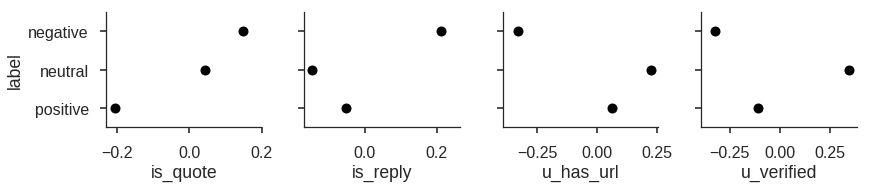

In [25]:
# Make the PairGrid
g = sns.PairGrid(df_t.unstack().reset_index().query(
    "results == 'Coef.'"
).drop(["level_3", "results"], axis=1).rename(columns={0: "value"}).pivot(
    index="label", columns="model_types", values="value"
).reset_index(),
                 x_vars=["is_quote", "is_reply", "u_has_url", "u_verified"],
                 y_vars=["label"],
                 size=3, aspect=1)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      color="k",
      #palette="Reds_r",
      edgecolor="gray")

# Use the same x axis limits on all columns and add better labels
#g.set(xlim=(0, 25), xlabel="Crashes", ylabel="")

# Use semantically meaningful titles for the columns
titles = ["Total crashes", "Speeding crashes", "Alcohol crashes",
          "Not distracted crashes", "No previous crashes"]


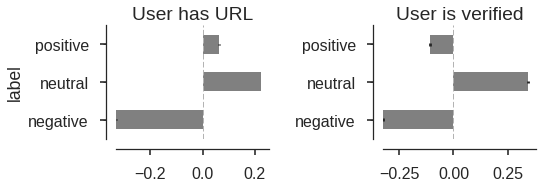

In [26]:
fig, ax = plt.subplots(1,2,sharey=True, figsize=(8,3))
x_labels = ["User has URL", "User is verified"]
for i, feature in enumerate(["u_has_url", "u_verified"]):    
    df_tt = df_t.unstack().reset_index().query(
        ("(results == 'Coef.' or results=='Std.Err.')"
         " and model_types == '%s'"
        ) % feature
    ).drop("level_3", axis=1).rename(
        columns={0: "value"}).pivot(index="label", columns="results", values="value"
                                   )
    df_tt.ix[["negative", "neutral", "positive"]].plot(kind="barh",
               y="Coef.", yerr='Std.Err.',
               color="0.5",
               ax=ax[i], legend=False, sort_columns=True)
    ax[i].set_title(x_labels[i])
    ax[i].axvline(x=0., lw=1, linestyle='--', color='0.7')

sns.despine(offset=10)
fig.tight_layout()        

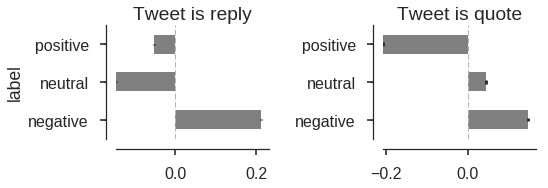

In [27]:
fig, ax = plt.subplots(1,2,sharey=True, figsize=(8,3))
x_labels = ["Tweet is reply", "Tweet is quote"]
for i, feature in enumerate(["is_reply", "is_quote"]):
    df_tt = df_t.unstack().reset_index().query(
        ("(results == 'Coef.' or results=='Std.Err.')"
         " and model_types == '%s'"
        ) % feature
    ).drop("level_3", axis=1).rename(
        columns={0: "value"}).pivot(index="label", columns="results", values="value"
                                   )
    df_tt.ix[["negative", "neutral", "positive"]].plot(kind="barh",
               y="Coef.", yerr='Std.Err.',
               color="0.5",
               ax=ax[i], legend=False, sort_columns=True)
    ax[i].set_title(x_labels[i])
    ax[i].axvline(x=0., lw=1, linestyle='--', color='0.7')

sns.despine(offset=10)
fig.tight_layout()        